In [137]:
# Colab usually comes with OpenCV / NumPy / Matplotlib, here we only add ipywidgets (parameter panel)
!pip -q install ipywidgets

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import clear_output
import ipywidgets as widgets

In [138]:
# Run this cell and select your cloudy aquarium photo to upload (jpg/png are both fine)
uploaded = files.upload()
# Record the filename of the first uploaded file (you can also specify it yourself)
img_path = next(iter(uploaded.keys()))
print("Using image:", img_path)

Saving IMG_0569.JPG to IMG_0569 (2).JPG
Using image: IMG_0569 (2).JPG


In [139]:
def imread_rgb(path):
    bgr = cv.imread(path, cv.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(path)
    return cv.cvtColor(bgr, cv.COLOR_BGR2RGB)

def imwrite_rgb(path, rgb):
    bgr = cv.cvtColor(rgb, cv.COLOR_RGB2BGR)
    cv.imwrite(path, bgr)

def show2(a, b, titleA="Original Image", titleB="Enhanced Image", figsize=(12,6)):
    plt.figure(figsize=figsize)
    plt.subplot(1,2,1); plt.imshow(a); plt.title(titleA); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(b); plt.title(titleB); plt.axis("off")
    plt.show()

In [140]:
def gray_world_wb(rgb):
    img = rgb.astype(np.float32)
    avg = img.reshape(-1,3).mean(0)
    k = avg.mean()
    gains = k / (avg + 1e-6)
    out = img * gains
    return np.clip(out, 0, 255).astype(np.uint8)

def guided_filter_guide(I, p, r=8, eps=1e-6):
    # I: guide, p: input (both gray)
    I = I.astype(np.float32)/255.; p = p.astype(np.float32)/255.
    ksize = (r, r)
    mean_I  = cv.boxFilter(I, -1, ksize)
    mean_p  = cv.boxFilter(p, -1, ksize)
    mean_Ip = cv.boxFilter(I*p, -1, ksize)
    cov_Ip  = mean_Ip - mean_I*mean_p

    mean_II = cv.boxFilter(I*I, -1, ksize)
    var_I   = mean_II - mean_I*mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a*mean_I

    mean_a = cv.boxFilter(a, -1, ksize)
    mean_b = cv.boxFilter(b, -1, ksize)
    q = mean_a*I + mean_b
    return np.clip(q*255, 0, 255).astype(np.uint8)

def fast_dehaze_cap(rgb, depth_blur_sigma=3, beta=1.15, t_floor=0.15):
    # CAP: d = 0.1 + 1*(1-V) + 0.9*S (HSV space)
    hsv = cv.cvtColor(rgb, cv.COLOR_RGB2HSV)
    V = hsv[:,:,2].astype(np.float32)/255.
    S = hsv[:,:,1].astype(np.float32)/255.
    d = 0.1 + 1.0*(1.0 - V) + 0.9*S
    d = cv.GaussianBlur(d, (0,0), depth_blur_sigma)

    t = np.exp(-beta*d)
    t = np.clip(t, t_floor, 1.0)

    A = np.percentile(rgb.reshape(-1,3), 95, axis=0).astype(np.float32)
    A = A[None,None,:]
    J = (rgb.astype(np.float32) - A)*(1.0/t[:,:,None]) + A
    J = np.clip(J, 0, 255).astype(np.uint8)

    # Refine in brightness using guided filter
    gray = cv.cvtColor(J, cv.COLOR_RGB2GRAY)
    refined = guided_filter_guide(gray, gray, r=6, eps=1e-4)
    J[:,:,0] = cv.addWeighted(J[:,:,0], 0.7, refined, 0.3, 0)
    J[:,:,1] = cv.addWeighted(J[:,:,1], 0.7, refined, 0.3, 0)
    J[:,:,2] = cv.addWeighted(J[:,:,2], 0.7, refined, 0.3, 0)
    return J

def apply_clahe_l(rgb, clipLimit=2.0, tileGridSize=(8,8)):
    lab = cv.cvtColor(rgb, cv.COLOR_RGB2LAB)
    l,a,b = cv.split(lab)
    clahe = cv.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    l2 = clahe.apply(l)
    out = cv.cvtColor(cv.merge([l2,a,b]), cv.COLOR_LAB2RGB)
    return out

def unsharp(rgb, sigma=1.0, amount=0.35):
    blur = cv.GaussianBlur(rgb, (0,0), sigma)
    sharp = cv.addWeighted(rgb, 1.0+amount, blur, -amount, 0)
    return np.clip(sharp, 0, 255).astype(np.uint8)

def detect_blue_strip_mask(rgb, h_low=80, h_high=140, s_low=40, v_low=40):
    hsv = cv.cvtColor(rgb, cv.COLOR_RGB2HSV)
    lower = np.array([h_low, s_low, v_low], dtype=np.uint8)
    upper = np.array([h_high, 255, 255], dtype=np.uint8)
    mask = cv.inRange(hsv, lower, upper)
    # Take the largest connected component (assuming only one strip)
    num_labels, labels, stats, _ = cv.connectedComponentsWithStats(mask, connectivity=8)
    if num_labels > 1:
        areas = stats[1:, cv.CC_STAT_AREA]
        largest_idx = 1 + np.argmax(areas)
        mask2 = (labels == largest_idx).astype(np.uint8)*255
    else:
        mask2 = mask
    mask2 = cv.morphologyEx(mask2, cv.MORPH_CLOSE, np.ones((9,9), np.uint8))
    mask2 = cv.dilate(mask2, np.ones((11,11), np.uint8), iterations=1)
    return mask2

def enhance_aquarium(
    rgb,
    beta=1.10, t_floor=0.18, clahe_clip=2.0, clahe_tile=8,
    unsharp_amount=0.35, unsharp_sigma=1.0,
    preserve_strip=True,
    h_low=80, h_high=140, s_low=40, v_low=40
):
    # 1) White balance
    wb = gray_world_wb(rgb)

    # 2) Dehaze (used for background)
    dehazed = fast_dehaze_cap(wb, depth_blur_sigma=3, beta=beta, t_floor=t_floor)

    # 3) CLAHE
    clahe = apply_clahe_l(dehazed, clipLimit=clahe_clip, tileGridSize=(clahe_tile, clahe_tile))

    # 4) Sharpening
    base_enhanced = unsharp(clahe, sigma=unsharp_sigma, amount=unsharp_amount)

    if not preserve_strip:
        return base_enhanced, None

    # 5) Strip mask: apply "mild processing" only within the strip, use enhanced image outside
    mask = detect_blue_strip_mask(rgb, h_low, h_high, s_low, v_low)
    strip_mild = cv.bilateralFilter(wb, d=7, sigmaColor=30, sigmaSpace=7)

    # Feather blending
    mask_float = (mask.astype(np.float32)/255.0)
    feather = cv.GaussianBlur(mask_float, (0,0), 7)
    feather3 = np.dstack([feather]*3)

    composited = (strip_mild * feather3 + base_enhanced * (1 - feather3)).astype(np.uint8)
    return composited, mask

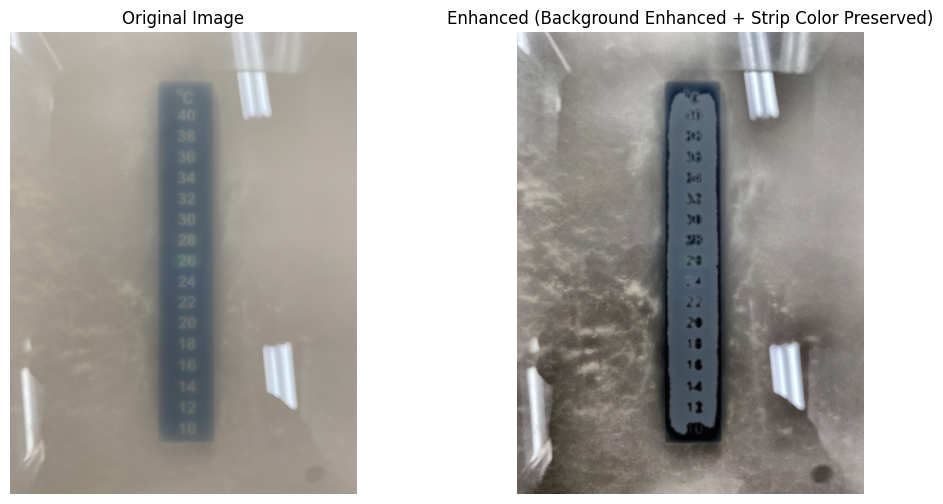

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [141]:
rgb = imread_rgb(img_path)
enhanced, mask = enhance_aquarium(
    rgb,
    beta=1.10, t_floor=0.18,
    clahe_clip=2.0, clahe_tile=8,
    unsharp_amount=0.35, unsharp_sigma=1.0,
    preserve_strip=True
)
show2(rgb, enhanced, "Original Image", "Enhanced (Background Enhanced + Strip Color Preserved)")

# Save and download
imwrite_rgb("aquarium_enhanced_preserve_strip.jpg", enhanced)
files.download("aquarium_enhanced_preserve_strip.jpg")

In [142]:
def demo(beta, t_floor, clahe_clip, clahe_tile, unsharp_amount, unsharp_sigma, preserve_strip):
    clear_output(wait=True)
    rgb = imread_rgb(img_path)
    enhanced, mask = enhance_aquarium(
        rgb,
        beta=float(beta), t_floor=float(t_floor),
        clahe_clip=float(clahe_clip), clahe_tile=int(clahe_tile),
        unsharp_amount=float(unsharp_amount), unsharp_sigma=float(unsharp_sigma),
        preserve_strip=bool(preserve_strip)
    )
    show2(rgb, enhanced, "Original Image", "Enhanced Image")
    imwrite_rgb("aquarium_enhanced_tuned.jpg", enhanced)
    print("Output saved as: aquarium_enhanced_tuned.jpg (download below)")
    #files.download("aquarium_enhanced_tuned.jpg")

_ = widgets.interact(
    demo,
    beta=widgets.FloatSlider(value=1.10, min=0.6, max=2.0, step=0.02, description='β'),
    t_floor=widgets.FloatSlider(value=0.18, min=0.05, max=0.5, step=0.01, description='t_floor'),
    clahe_clip=widgets.FloatSlider(value=2.0, min=1.0, max=5.0, step=0.1, description='CLAHE Clip Limit'),
    clahe_tile=widgets.IntSlider(value=8, min=4, max=16, step=1, description='CLAHE Tile Size'),
    unsharp_amount=widgets.FloatSlider(value=0.35, min=0.0, max=1.0, step=0.05, description='Unsharp Mask Amount'),
    unsharp_sigma=widgets.FloatSlider(value=1.0, min=0.5, max=3.0, step=0.1, description='Unsharp Mask Sigma'),
    preserve_strip=widgets.Checkbox(value=True, description='Preserve Strip Color / No Enhance')
)

interactive(children=(FloatSlider(value=1.1, description='β', max=2.0, min=0.6, step=0.02), FloatSlider(value=…

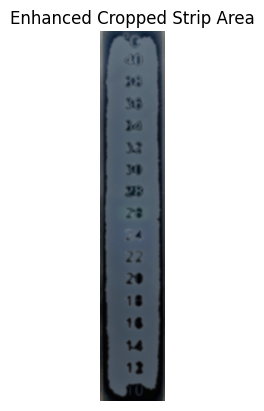

In [143]:
# Automatically crop the strip area using the detected strip mask and save the image
rgb = imread_rgb(img_path)
enhanced, mask = enhance_aquarium(rgb, preserve_strip=True)
if mask is not None and mask.any():
    ys, xs = np.where(mask > 0)
    x0, x1 = xs.min(), xs.max()
    y0, y1 = ys.min(), ys.max()
    pad = 40
    x0 = max(0, x0 - pad); y0 = max(0, y0 - pad)
    x1 = min(rgb.shape[1]-1, x1 + pad); y1 = min(rgb.shape[0]-1, y1 + pad)
    crop = enhanced[y0:y1, x0:x1]
    imwrite_rgb("therm_strip_crop_enhanced.jpg", crop)
    plt.imshow(crop); plt.axis("off"); plt.title("Enhanced Cropped Strip Area")
    plt.show()
    #files.download("therm_strip_crop_enhanced.jpg")
else:
    print("Strip mask not detected. Please adjust mask parameters (H/S/V ranges).")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

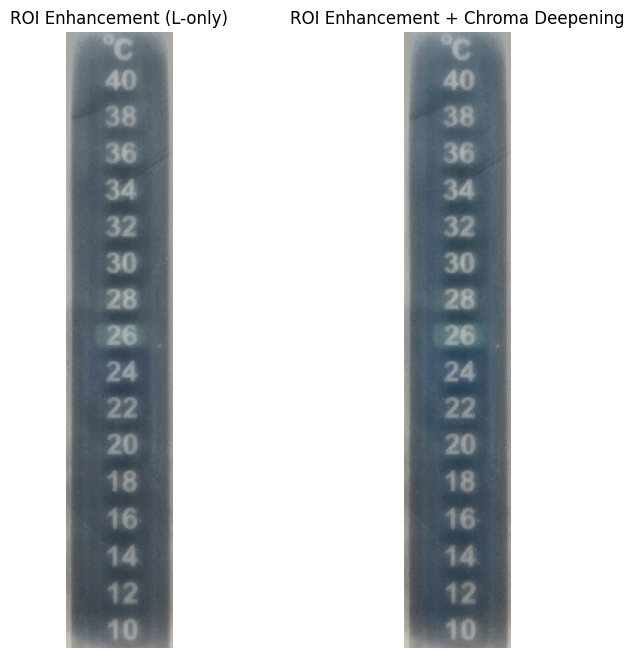

In [144]:
# === ROI Enhancement (L-only) + ROI Enhancement + Chroma Deepening ===
# Input is the original cloudy aquarium photo (temperature strip should be visible)
# Two images will be output after execution: L-only and with color added

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# === 1. Read Original Image ===
orig_path = img_path   # ← e.g., 'fish_tank.JPG'
rgb = cv.cvtColor(cv.imread(orig_path), cv.COLOR_BGR2RGB)

# === 2. Detect Strip Area (Blue-Green Range) ===
def detect_blue_strip_mask(rgb, h_low=80, h_high=140, s_low=40, v_low=40):
    hsv = cv.cvtColor(rgb, cv.COLOR_RGB2HSV)
    lower = np.array([h_low, s_low, v_low], np.uint8)
    upper = np.array([h_high, 255, 255], np.uint8)
    mask = cv.inRange(hsv, lower, upper)
    num, labels, stats, _ = cv.connectedComponentsWithStats(mask, 8)
    if num > 1:
        idx = 1 + np.argmax(stats[1:, cv.CC_STAT_AREA])
        mask = (labels == idx).astype(np.uint8) * 255
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, np.ones((9,9), np.uint8))
    mask = cv.dilate(mask, np.ones((11,11), np.uint8), 1)
    return mask

mask = detect_blue_strip_mask(rgb)

ys, xs = np.where(mask > 0)
x0, x1, y0, y1 = xs.min(), xs.max(), ys.min(), ys.max()
pad = 40
x0, y0 = max(0, x0-pad), max(0, y0-pad)
x1, y1 = min(rgb.shape[1]-1, x1+pad), min(rgb.shape[0]-1, y1+pad)
roi = rgb[y0:y1, x0:x1].copy()

# === 3. ROI Enhancement (L-only) ===
lab = cv.cvtColor(roi, cv.COLOR_RGB2LAB)
L, a, b = cv.split(lab)

# Brightness smoothing + CLAHE
p98 = np.percentile(L, 98)
L = np.clip(L, 0, p98).astype(np.uint8)
clahe = cv.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
L2 = clahe.apply(L)

# Sharpening + slight deconvolution
blurL = cv.GaussianBlur(L2, (0,0), 0.8)
L3 = cv.addWeighted(L2, 1.5, blurL, -0.5, 0)

# Save L-only enhanced image
roi_Lonly = cv.cvtColor(cv.merge([L3, a, b]), cv.COLOR_LAB2RGB)
cv.imwrite("therm_strip_roi_Lonly.jpg", cv.cvtColor(roi_Lonly, cv.COLOR_RGB2BGR))
files.download("therm_strip_roi_Lonly.jpg")

# === 4. ROI Enhancement + Chroma Deepening ===
a32, b32 = a.astype(np.float32)-128.0, b.astype(np.float32)-128.0
C = np.sqrt(a32*a32 + b32*b32)
gain = 1.25  # Chroma amplification factor (1.15~1.35)
th = 6.0     # Only strengthen areas with chroma > th to avoid white text being colored

mask_boost = (C > th).astype(np.float32)
a_boost = 128.0 + a32*(1+(gain-1)*mask_boost)
b_boost = 128.0 + b32*(1+(gain-1)*mask_boost)
a_boost = np.clip(a_boost,0,255).astype(np.uint8)
b_boost = np.clip(b_boost,0,255).astype(np.uint8)

roi_chroma = cv.cvtColor(cv.merge([L3,a_boost,b_boost]), cv.COLOR_LAB2RGB)
cv.imwrite("therm_strip_roi_chroma.jpg", cv.cvtColor(roi_chroma, cv.COLOR_RGB2BGR))
files.download("therm_strip_roi_chroma.jpg")

# === 5. Display Comparison ===
plt.figure(figsize=(8,8))
plt.subplot(1,2,1); plt.imshow(roi_Lonly); plt.title("ROI Enhancement (L-only)"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(roi_chroma); plt.title("ROI Enhancement + Chroma Deepening"); plt.axis("off")
plt.show()

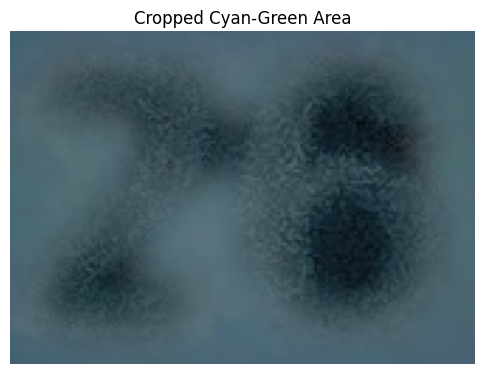

In [152]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Read the enhanced and composited image
input_image_path = "aquarium_roi_enhanced_chroma_on_bg.jpg"
input_rgb = cv.cvtColor(cv.imread(input_image_path), cv.COLOR_BGR2RGB)

if input_rgb is None:
    print(f"Error: Could not read image {input_image_path}. Please ensure it exists and the path is correct.")
else:
    # Convert to HSV color space
    input_hsv = cv.cvtColor(input_rgb, cv.COLOR_RGB2HSV)

    # Define HSV range for cyan-green (may need adjustment based on the image)
    # These values are based on the previous detection but might need fine-tuning for the enhanced image
    lower_cyan_green = np.array([80, 70, 50], dtype=np.uint8)
    upper_cyan_green = np.array([100, 250, 100], dtype=np.uint8)

    # Create a mask for the cyan-green color range
    cyan_green_mask = cv.inRange(input_hsv, lower_cyan_green, upper_cyan_green)

    # Optional: Apply morphological operations to clean up the mask
    # This can help remove noise and connect small gaps
    # cyan_green_mask = cv.morphologyEx(cyan_green_mask, cv.MORPH_OPEN, np.ones((3,3), np.uint8))
    # cyan_green_mask = cv.morphologyEx(cyan_green_mask, cv.MORPH_CLOSE, np.ones((5,5), np.uint8))

    # Find contours to identify the green areas and find the largest one (assuming it's the main green strip)
    contours, _ = cv.findContours(cyan_green_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    if contours:
        # Find the largest contour
        largest_contour = max(contours, key=cv.contourArea)

        # Get the bounding box of the largest contour
        x, y, w, h = cv.boundingRect(largest_contour)

        # Add some padding around the bounding box for better visualization (optional)
        pad = 10
        x_start = max(0, x - pad)
        y_start = max(0, y - pad)
        x_end = min(input_rgb.shape[1], x + w + pad)
        y_end = min(input_rgb.shape[0], y + h + pad)


        # Crop the original image using the bounding box
        cropped_green_area = input_rgb[y_start:y_end, x_start:x_end]

        # Display the cropped green area
        plt.figure(figsize=(6, 6))
        plt.imshow(cropped_green_area)
        plt.title("Cropped Cyan-Green Area")
        plt.axis("off")
        plt.show()

        # Optional: Save the cropped image
        # cv.imwrite("cropped_cyan_green_area.jpg", cv.cvtColor(cropped_green_area, cv.COLOR_RGB2BGR))
        # print("Cropped image saved as cropped_cyan_green_area.jpg")
    else:
        print("No significant cyan-green area detected with the current HSV range.")